<h1>SUBSET SELECTION</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns
import xlrd
import time
import statsmodels.api as sm

In [2]:
data=pd.read_excel('Data/Mini Project EFSA.xlsx')
data.rename(columns={'sex \n(0=M, 1=F)':'sex'}, inplace=True)
data

,response,number of animals,SD,dose,sex,endpoint
0,570.4,9,75.6,0,0,1
1,548.5,10,44.3,30,0,1
2,533.0,10,72.3,100,0,1
3,488.1,9,42.5,150,0,1
4,329.8,10,46.8,0,1,1
5,319.7,10,24.3,30,1,1
6,293.3,10,20.1,100,1,1
7,312.4,10,43.1,150,1,1
8,45.2,9,1.5,0,0,2
9,44.6,10,1.7,30,0,2


In [3]:
def processSubset(X,feature_set,weights):
    # Fit model on feature_set and calculate RSS
    #model = sm.OLS(y,X[list(feature_set)])
    model = sm.WLS(y,X[list(feature_set)],weights=weights)
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [4]:
def forward(X,predictors,weights):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X,predictors+[p],weights))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

<h2>I dati sono le colonne originali</h2>

In [5]:
#Prepare the datas
y = data.response
weights = data.SD
X = data.drop(columns=["response","SD"])

#Devo estrarre l'endpoint dalla matrice in modo da avere 2 variabili categoriche usate per fare i 3 endpoint
endpoint1 = X['endpoint'] == 1
endpoint2 = X['endpoint'] == 2
X["endpoint1"] = endpoint1.astype("int")
X["endpoint2"] = endpoint2.astype("int")
X = X.drop(columns=["endpoint"])


In [6]:
X

,number of animals,dose,sex,endpoint1,endpoint2
0,9,0,0,1,0
1,10,30,0,1,0
2,10,100,0,1,0
3,9,150,0,1,0
4,10,0,1,1,0
5,10,30,1,1,0
6,10,100,1,1,0
7,10,150,1,1,0
8,9,0,0,0,1
9,10,30,0,0,1


<h1>2 - Use subset selection to estimate separate models for the 3 endpoints using gender as categorical variable.</h1>

<h1>3 - Use subset selection to estimate a unique model using gender and endpoint as categorical variables</h1>
<h2>Forward</h2>

In [7]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(X,predictors,weights)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  5 models on 1 predictors in 1.3192903995513916 seconds.
Processed  4 models on 2 predictors in 0.24465727806091309 seconds.
Processed  3 models on 3 predictors in 0.057039737701416016 seconds.
Processed  2 models on 4 predictors in 0.012201547622680664 seconds.
Processed  1 models on 5 predictors in 0.008153438568115234 seconds.
Total elapsed time: 1.7131719589233398 seconds.


In [8]:
display(models_fwd)

,RSS,model
1,129317.782939,<statsmodels.regression.linear_model.Regressio...
2,114179.823869,<statsmodels.regression.linear_model.Regressio...
3,130492.196556,<statsmodels.regression.linear_model.Regressio...
4,343912.588939,<statsmodels.regression.linear_model.Regressio...
5,191908.905107,<statsmodels.regression.linear_model.Regressio...


In [62]:
models_fwd.RSS

1    129317.782939
2    114179.823869
3    111648.891968
4    115581.495580
5    115785.302814
6    188282.474009
Name: RSS, dtype: float64

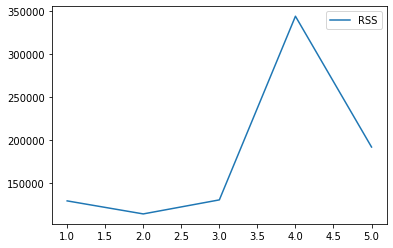

In [9]:
models_fwd.plot()